# Boardgame analysis 

## TODO Introduction
- brief description of what the data is
- brief description of how I got the data
- link to blogposts

In [1]:
# Import, settings, and constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud
import random
from IPython.display import display
from core import analysis_utils as au
from core.analysis_utils import print_titled_text as titled, print_spacer as spacer
from warnings import warn
from string import Template

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')

PATH_GENERAL_DATA = "./data/parquet/2022-09-19_general_data.parquet"
PATH_LINK_DATA = "./data/parquet/2022-09-19_link_data.parquet"
PATH_POLL_DATA = "./data/parquet/2022-09-19_poll_data.parquet"

In [2]:
%%time
# Load the data
gen = pd.read_parquet(PATH_GENERAL_DATA)
link = pd.read_parquet(PATH_LINK_DATA)
poll = pd.read_parquet(PATH_POLL_DATA)

CPU times: user 3.98 s, sys: 4.13 s, total: 8.11 s
Wall time: 6.17 s


## General properties of the imported dataframes

## General Data


### Rated vs Unrated games

Games on BGG may be rated by users out of 10. Games that receive 30+ user ratings are assigned a ["geek rating"](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ#toc13). This geek rating is used to rank board games against each other, and is necessary to prevent games with a few high rankings from appearing higher than games with a large number of rankings. For example, one may not want a game with five ratings of 10 to be considered a 'better' board game than a game with a ratings mean at 4.8 but 100K ratings.

The exact calculation method for the geek rating is not published by BGG, but it is apparently mostly a [bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).
Indeed, in the original XML data this field is called `bayesaverage`.


In this dataset, the geek rating is called the `ratings_bayes_average`, and unrated games received a score of zero for this field.
- we know from previously that 
- 
- [could be 100 votes at 5.5](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ)
- [previous estimate of 1500-1600 ratings of 5.5](https://boardgamegeek.com/blogpost/109537/reverse-engineering-boardgamegeek-ranking)
, and I've changed it to `ratings_bayes_average` in the processed data.

In [3]:
rated = gen.query('ratings_bayes_average > 0')
unrated = gen.query('ratings_bayes_average == 0')

In [4]:
(unrated['ratings_n'] == 0).mean()

0.31770900976421834

In [5]:
np.histogram(unrated['ratings_n'])

(array([50373, 13058,  6519,  4058,  2833,  2252,  1785,  1491,  1250,
         1078]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]))

In [6]:
print(f"Number of games without/with geek rating: \n    "
      f"w/o - {unrated.shape[0]}, "
      f"w/ - {rated.shape[0]}."
     )

print(f"Without geek number of ratings min, max: "
      f"{unrated['ratings_n'].min()}, "
      f"{unrated['ratings_n'].max()}."
     )

print(f"With geek number of ratings min, max: "
      f"{rated['ratings_n'].min()}, "
      f"{rated['ratings_n'].max()}."
     )

Number of games without/with geek rating: 
    w/o - 84697, w/ - 23318.
Without geek number of ratings min, max: 0, 29.
With geek number of ratings min, max: 30, 113935.


- for games with more than thirty ratings, BGG obscures the actual ratings. This is because they have to rank the games. Games with a low number of ratings may have a high average rating because a very small number of highly-rated games.
- therefore bgg obscures these game ratings with dummy ratings
- here's a visualization of what that looks like

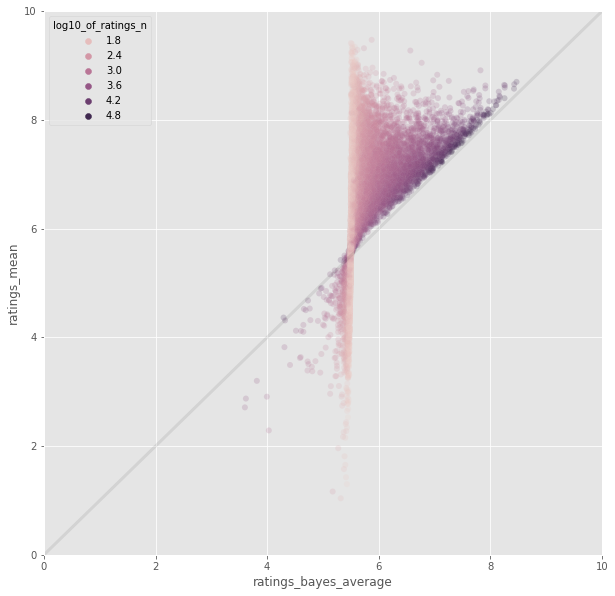

In [7]:
_data = rated.assign(log10_of_ratings_n = np.log10(rated['ratings_n']))
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(ax=ax, data=_data, x='ratings_bayes_average', y='ratings_mean',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

- we know from previously that 
- [bayesian average](https://en.wikipedia.org/wiki/Bayesian_average)
- [could be 100 votes at 5.5](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ)
- [previous estimate of 1500-1600 ratings of 5.5](https://boardgamegeek.com/blogpost/109537/reverse-engineering-boardgamegeek-ranking)



In [8]:
def compute_bayesian_average(rating_mean, rating_n, dummy_rating, num_dummies):
    return (
        ((rating_mean * rating_n) + (dummy_rating * num_dummies))
        /(rating_n + num_dummies)
        )

def vec_compute_bayesian_average(df, dummy_rating, num_dummies):
    return (
        ((df.ratings_mean * df.ratings_n) + (dummy_rating * num_dummies))
        /(df.ratings_n + num_dummies)
        )

def rmsd(y_trues, y_preds):
    """Compute RMSD.
    
    Args:
        y_ratings (np.ndarray or pd.Series): A 1D vector.
        y_preds (np.ndarray or pd.Series): A 1D vector.
    Returns:
        float: the root mean squared deviation.
    """
    assert len(y_trues.shape) == 1
    assert y_trues.shape == y_preds.shape
    return np.sqrt(((y_trues - y_preds)**2).sum() / y_trues.shape[0])

# Tests
def test_compute_bayes_average():
    mean, rating_n, dummy, num_dummies = 2, 3, 4, 5
    correct = 3.25
    result = compute_bayesian_average(mean, rating_n, dummy, num_dummies) 
    try: 
        assert result == correct 
    except AssertionError:
        print(f"FAIL: result was {result}, but should be {correct}.")
    else:
        print(f"PASS")

def test_vec_compute_bayesian_average():
    dummy, num_dummies = 5, 2
    df = pd.DataFrame({'ratings_mean':[1,1,2], 'ratings_n':[1,2,3]})
    correct = pd.Series([11/3, 12/4, 16/5])
    result = vec_compute_bayesian_average(df, dummy, num_dummies)
    try:
        assert np.equal(result.values, correct.values).all()
    except AssertionError:
        print(f"FAIL: result was \n{result}\n but should be \n{correct}.")
    else:
        print(f"PASS")

def test_rmsd():
    result = rmsd(np.array([1,2,3]), np.array([4,7,11]))
    correct = np.sqrt(98/3)
    try:
        assert result == correct
    except AssertionError:
        print(f"FAIL: result was {result}, but should be {correct}.")
    else:
        print(f"PASS")

test_compute_bayes_average()
test_vec_compute_bayesian_average()
test_rmsd()

PASS
PASS
PASS


In [9]:
bayes = (
    rated
    .assign(computed_bayes=vec_compute_bayesian_average(rated, 5.5, 1500))
)

print(f"RMSD computed Bayesian average: "
      f"{rmsd(bayes.computed_bayes, bayes.ratings_bayes_average):.6f}")

RMSD computed Bayesian average: 0.051999


In [10]:
from scipy.optimize import minimize

def error_wrapper(dummy_args):
    (dummy_rating, num_dummies) = dummy_args

    y_true = rated.ratings_bayes_average
    y_pred = vec_compute_bayesian_average(rated, dummy_rating, num_dummies) 
    error = rmsd(y_true, y_pred)
    return error 
    
print(error_wrapper((5.5, 1500)))

0.051999322298702674


In [11]:
op_res = minimize(error_wrapper, (5.5, 1500), options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.019480
         Iterations: 34
         Function evaluations: 108
         Gradient evaluations: 36


In [12]:
# Bad start x0 test
minimize(error_wrapper, (0, 0), options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.019480
         Iterations: 29
         Function evaluations: 120
         Gradient evaluations: 40


      fun: 0.019480321333741443
 hess_inv: array([[3.26293011e-02, 1.65853798e+02],
       [1.65853798e+02, 3.77780220e+06]])
      jac: array([-1.60885975e-07, -4.65661287e-10])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 29
     njev: 40
   status: 0
  success: True
        x: array([   5.49561749, 1972.45674022])

In [13]:
print(op_res.x)

[   5.49561746 1972.46000073]


In [14]:
# TODO delete this
rmsd(rated.ratings_bayes_average, vec_compute_bayesian_average(rated, *op_res.x))



0.019480321333279833

In [15]:
rmsd(rated.ratings_bayes_average, vec_compute_bayesian_average(rated, 5.5, 2000))

0.019786248036724324

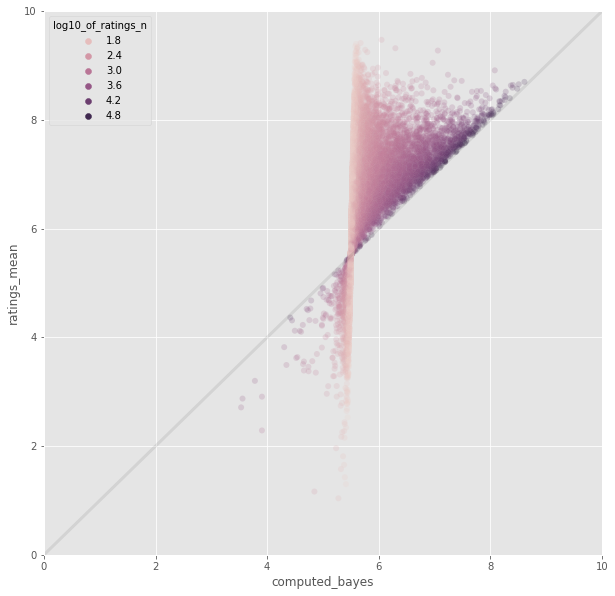

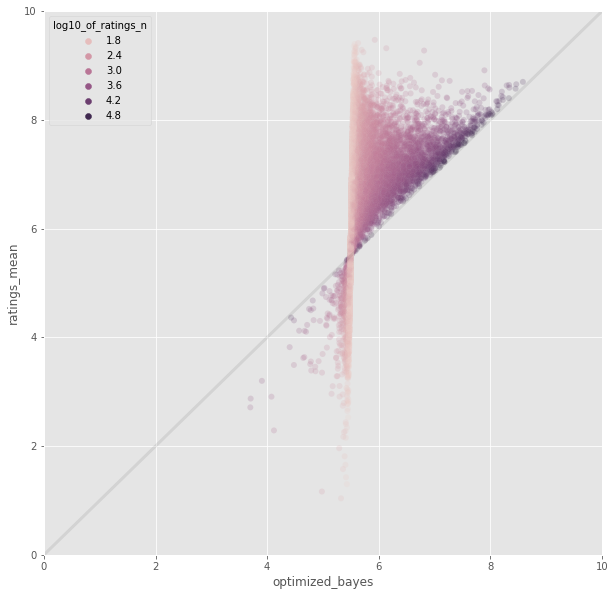

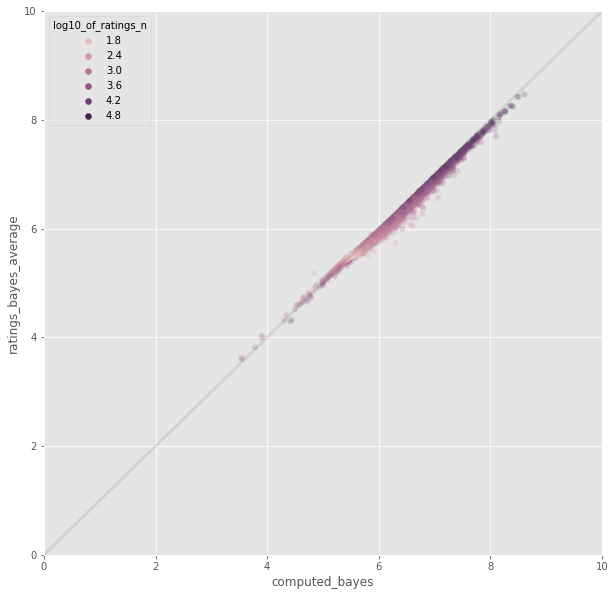

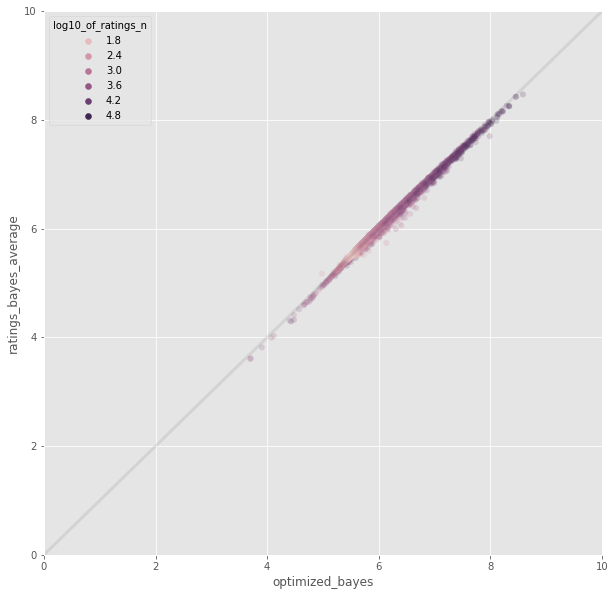

In [16]:
_data = (
    rated
    .assign(log10_of_ratings_n = np.log10(rated['ratings_n']))
    .assign(computed_bayes=vec_compute_bayesian_average(rated, 5.5, 1500))
    .assign(optimized_bayes=vec_compute_bayesian_average(rated, *op_res.x))
)

f, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(ax=ax, data=_data, x='computed_bayes', y='ratings_mean',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

f, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(ax=ax, data=_data, x='optimized_bayes', y='ratings_mean',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');


f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(ax=ax, data=_data, x='computed_bayes', y='ratings_bayes_average',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(ax=ax, data=_data, x='optimized_bayes', y='ratings_bayes_average',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

In [123]:
def plot_residuals_vs_n_ratings(
        df,
        a_key,
        b_key,
        ratings_n_key='ratings_n',
        figsize=(10, 5)):
    x = np.log10(df[ratings_n_key]).rename('log10_ratings_n')
    y = (df[a_key] - df[b_key]).rename(f"{a_key} minus {b_key}") 
    f, ax = plt.subplots(1, 1 , figsize=figsize)
    sns.scatterplot(
        ax=ax,
        x=x,
        y=y,
        linewidth=0,
        alpha=0.2,
        color='#555',
        )
    return ax


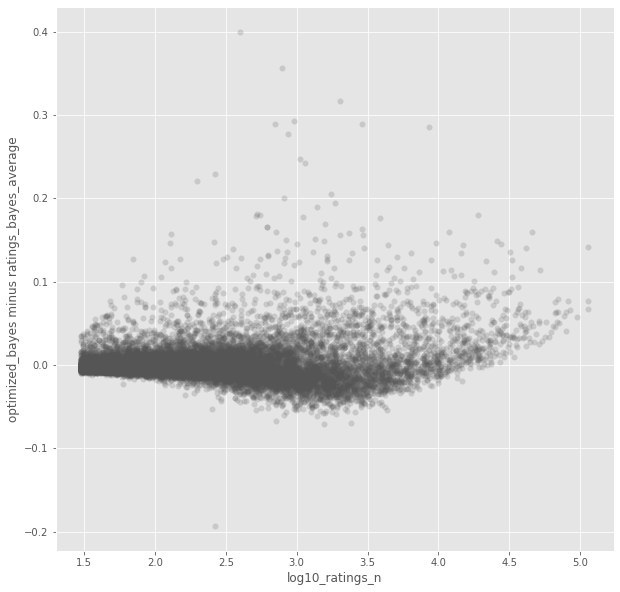

In [124]:
plot_residuals_vs_n_ratings(_data, 'optimized_bayes', 'ratings_bayes_average', figsize=(10,10));

- split the data into rated and unrated parts for individual variable overview.

## Inspecting rated game properties 

- missing values
- dupes

In [19]:
rated.head(3).T

,3,12,13
id,13260,10502,257273
type,boardgame,boardgame,boardgame
name,Clown,Poker Dice,Ghosts of the Moor
description,The players roll a die to get one of the tile ...,Poker Dice is a dice game using five (5) speci...,Guide your intrepid explorers through the curs...
year_published,1975,0,2018
players_min,2,2,2
players_max,6,12,5
playtime,20,10,30
playtime_min,20,10,20
playtime_max,20,10,30


In [20]:
rated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23318 entries, 3 to 108014
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       23318 non-null  int64  
 1   type                     23318 non-null  object 
 2   name                     23318 non-null  object 
 3   description              23317 non-null  object 
 4   year_published           23318 non-null  int64  
 5   players_min              23318 non-null  int64  
 6   players_max              23318 non-null  int64  
 7   playtime                 23318 non-null  int64  
 8   playtime_min             23318 non-null  int64  
 9   playtime_max             23318 non-null  int64  
 10  age_min                  23318 non-null  int64  
 11  ratings_n                23318 non-null  int64  
 12  ratings_mean             23318 non-null  float64
 13  ratings_bayes_average    23318 non-null  float64
 14  ratings_stddev       

In [21]:
# Store for Data Viewer
rated_cols = pd.Series(rated.columns)

In [22]:
# Count NAs
rated.isna().sum().pipe(lambda s: s[s > 0])

description    1
dtype: int64

In [23]:
# Check for duplicates
rated.duplicated().sum()

0

In [24]:
# How many 0's are in non-rating columns
# i.e. missing value placeholder
(rated
    .loc[:, 'id':'age_min']
    .eq(0)
    .sum()
)

id                   0
type                 0
name                 0
description          0
year_published     201
players_min         52
players_max        177
playtime           897
playtime_min       736
playtime_max       897
age_min           1390
dtype: int64

In [25]:
rated.describe()

,id,year_published,players_min,players_max,playtime,playtime_min,playtime_max,age_min,ratings_n,ratings_mean,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
count,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.0,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000
mean,126683.275066,1986.641779,1.995454,5.755168,90.825028,62.452397,90.825028,9.639892,887.455614,6.439447,5.682265,1.524332,0.0,1528.389527,43.067416,40.946779,237.395789,212.212068,48.754096,1.979245
std,110356.808154,209.545550,0.699209,14.898702,522.300785,431.042046,522.300785,3.649204,3799.808928,0.937372,0.362250,0.293628,0.0,5599.966889,103.150991,114.608912,820.796402,679.267515,205.750925,0.850962
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.039000,3.601000,0.191200,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,13884.250000,2002.000000,2.000000,4.000000,25.000000,20.000000,25.000000,8.000000,56.000000,5.850000,5.510000,1.324825,0.0,150.000000,5.000000,3.000000,14.000000,24.000000,4.000000,1.333000
50%,123595.500000,2012.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,124.000000,6.468000,5.544000,1.483600,0.0,325.000000,13.000000,9.000000,40.000000,50.000000,9.000000,1.974500
75%,221289.250000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,401.000000,7.070000,5.672000,1.672050,0.0,921.000000,37.000000,28.000000,133.000000,138.000000,25.000000,2.514000
max,362202.000000,2023.000000,10.000000,999.000000,60000.000000,60000.000000,60000.000000,21.000000,113935.000000,9.473000,8.469000,4.417600,0.0,178195.000000,2741.000000,1960.000000,20430.000000,20125.000000,7854.000000,5.000000


In [26]:
rated.columns

Index(['id', 'type', 'name', 'description', 'year_published', 'players_min',
       'players_max', 'playtime', 'playtime_min', 'playtime_max', 'age_min',
       'ratings_n', 'ratings_mean', 'ratings_bayes_average', 'ratings_stddev',
       'ratings_median', 'ratings_owned', 'ratings_trading', 'ratings_wanting',
       'ratings_wishing', 'ratings_comments_n', 'ratings_weights_n',
       'ratings_weights_average'],
      dtype='object')

In [27]:
# Memory usage in MB
rated.memory_usage(deep=True, index=True).sum()/(2**20)

44.761733055114746

### ID values

Each boardgame has a unique id.
Binning the ids shows that there are "missing" ids (i.e. with bin widths of 10000, bin counts don't reach 10000).
The cumulative count has a slope change at around id == 50,000.
This slope change is also present when plotting all games (i.e. not just rated games).

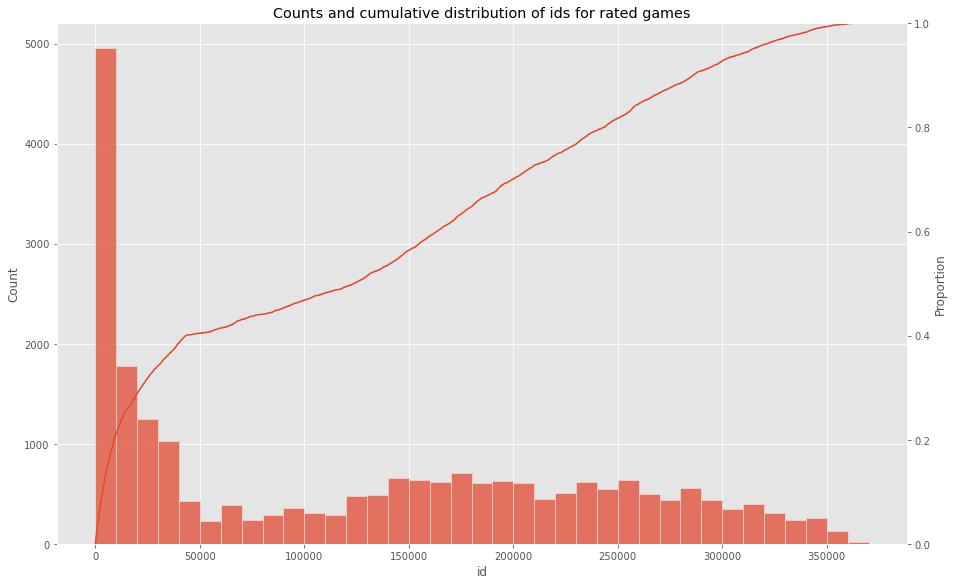

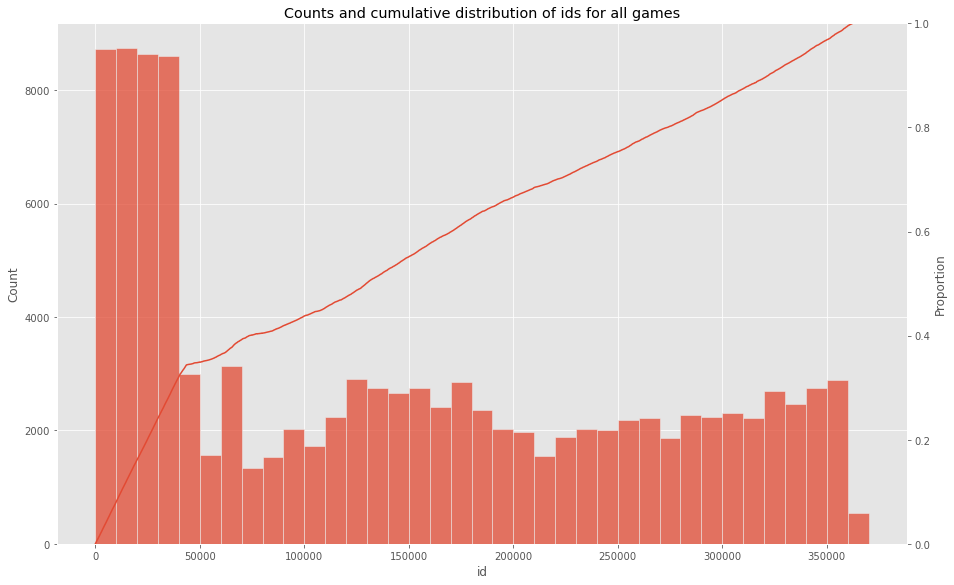

In [28]:
def plot_ids_dist(df):
    g = sns.displot(
        data=df,
        x='id',
        binwidth=10_000,
        height=8,
        aspect=1.6)
    ax2 = sns.ecdfplot(
        ax=g.ax.twinx(),
        data=df,
        x='id')
    ax2.grid(False)
    return g

g = plot_ids_dist(rated)
g2 = plot_ids_dist(gen)
g.set(title='Counts and cumulative distribution of ids for rated games');
g2.set(title='Counts and cumulative distribution of ids for all games');


Most of the missing ids for rated games are because we subsetted all games.
Additionally, some ids are assigned to board game expansions, which we did not include in this data table.

Let's look at the data for all games. A cursory sampling of games before and after id ~50k suggests that ids after 50k include items for RPGs and video games. This is because [videogamegeek.com] and [rpggeek.com] share a common id system. The slope change at id ~50k is probably when they started tracking video games and rpg items.

Missings ids also include ids that are no longer assigned to any item (e.g. 20723), redirects (e.g. 9517 redirects to 2065).

In [29]:
def sample_missing_ids(id_s, start, end, n=5, random_seed=None):
    # Get a full set of ids within a range
    # and subtract ids from id series that
    # are in that range.
    full = {i for i in range(start, end + 1)}
    current = set(id_s
        .sort_values()
        .pipe(lambda s: s[(s >= start) & (s <= end)])
        )
    missing = full - current
    # Sample the missing ids.
    # Sampling from sets is deprecated.
    random.seed(a=random_seed)
    return random.sample([*missing], n)

(pd.DataFrame(
        {'early': sample_missing_ids(gen.id, 20000, 30000, random_seed=7),
         'late': sample_missing_ids(gen.id, 120000, 130000, random_seed=7)})
    .style.format(
        lambda id: 
            f'<a target="_blank" '
            f'href="https://boardgamegeek.com/boardgame/{id}">'
            f'{id}'
            f'</a>',
    )
)

,early,late
0,28942,123591
1,27102,121658
2,29492,124424
3,24377,127252
4,25560,120516


### Type 

Only items of type `boardgame` were downloaded from the server, (excluding boardgame expansions and accessories), so having only one type here is expected.

In [30]:
rated['type'].value_counts()

boardgame    23318
Name: type, dtype: int64

### Name and Description
There are no missing values and empty strings for the name field.


In [31]:
print(rated.name.isna().sum())
print((rated.name == '').sum())

0
0


There are a few hundred duplicated names, but a quick peek suggests that they really are different games with the same name.

In [32]:
name_dupes = rated.name.value_counts().pipe(lambda s: s[s>1])
print(name_dupes.shape)
spacer(1)
print(name_dupes.head(3))
spacer(1)
print(name_dupes.tail(3))

(383,)


Robin Hood                     6
Warhammer 40,000: Kill Team    4
Chaos                          4
Name: name, dtype: int64


Totem           2
Star Traders    2
Six             2
Name: name, dtype: int64


In [33]:
rated[rated.name.isin(name_dupes.index[[0]])]

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
24245,1947,boardgame,Robin Hood,The game has several different scenarios. Each...,1991,2,6,60,60,60,...,5.501,1.4515,0.0,199,9,9,8,21,5,2.40
41664,104640,boardgame,Robin Hood,Robin Hood is a rethemed and revised version o...,2011,3,5,50,50,50,...,5.647,1.3968,0.0,268,11,30,99,49,18,1.50
51007,31794,boardgame,Robin Hood,Robin Hoodis an adventure game with a mixed Ki...,1994,2,2,60,60,60,...,5.464,1.4303,0.0,113,6,3,8,14,5,1.60
58304,136,boardgame,Robin Hood,Robin Hood and his Merry Men are trying to gra...,1999,3,6,30,30,30,...,5.496,1.4390,0.0,230,16,2,9,31,4,1.75
64768,258137,boardgame,Robin Hood,"If you liked Hammer of the Scots and Cowboys, ...",2019,2,2,120,60,120,...,5.536,1.4756,0.0,193,9,12,48,33,4,2.75
70832,3569,boardgame,Robin Hood,Robin Hood is played in four rounds. At the en...,1990,2,6,60,60,60,...,5.510,1.1410,0.0,222,16,5,9,40,5,1.40


In [34]:
rated[rated.name.isin(name_dupes.index[-3:])].sort_values(by='name')

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
73945,20195,boardgame,Six,Six is a deceptively simple-looking abstract s...,2003,2,4,20,20,20,...,5.683,1.4055,0.0,943,29,28,170,236,35,1.657
85320,34958,boardgame,Six,Six is played in only six minutes. 2 to 5 play...,2008,2,5,6,6,6,...,5.502,1.6185,0.0,125,10,1,9,38,13,1.000
40079,673,boardgame,Star Traders,from user review:\nEach player assumes the rol...,1987,2,6,120,120,120,...,5.585,1.3797,0.0,463,32,16,48,89,22,2.318
72255,193577,boardgame,Star Traders,"In the year 3250, the Galactic Empire is at pe...",2016,2,6,180,20,180,...,5.536,1.8112,0.0,125,6,2,8,18,4,2.000
74207,471,boardgame,Totem,from the rules summary from Game Cabinet:\n\nT...,1995,2,4,90,90,90,...,5.492,1.5588,0.0,294,22,3,10,35,10,2.500
86243,209378,boardgame,Totem,Let the Spirits guide your totems to victory!\...,2016,2,4,0,30,0,...,5.487,1.3703,0.0,223,8,2,4,25,1,2.000


There is one missing description, but no empty strings in the description.

In [35]:
rated.query("description.isna()")

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
28357,170984,boardgame,Timeline: Sports et Loisirs,None,2014,2,8,15,15,15,...,5.533,1.6166,0.0,178,2,7,32,10,2,1.0


In [36]:
(rated.description == '').sum()

0

There are games with duplicated descriptions, but (for at least some of them) this is due to to games being expansions that can also be played stand-alone (e.g. Rory's story cubes), or games that are delivered in multiple stand-alone parts (e.g. Austerlitz 1805: Partie Nord/Sud were published in two separate issues of a gaming magazine (where the pieces could be cut out), with both parts being separately playable and combinable).

In [37]:
rated.description[rated.description.duplicated(keep=False)]

2140      Everything good comes at a cost. What are you ...
14789     How could that have happened? Black Stories ar...
15638     How could that have happened? Black Stories ar...
20721     The award winning game Orcs Must Die has made ...
24359     Dice Throne is a game of intriguing dice, tact...
25109     The game is a detective game where you get set...
30505     A large game from Vae Victis, this game stretc...
40758     Everything good comes at a cost. What are you ...
45998     How could that have happened? Black Stories ar...
49477     An expansion to the creativity game Rory's Sto...
50017     A large game from Vae Victis, this game stretc...
52578     Dice Throne is a game of intriguing dice, tact...
52594     The epic Egyptian game Kemet is reborn with a ...
54821     An expansion to the creativity game Rory's Sto...
54864     Critical Mass is a fast-paced mech combat game...
55600     How could that have happened? Black Stories ar...
59883     Dice Throne is a game of intri

In [38]:
(rated
    [rated.duplicated(subset='description', keep=False)]
    .sort_values(by='description')
    [['id', 'name', 'description', 'year_published']]
)

,id,name,description,year_published
30505,13218,Austerlitz 1805: Partie Sud,"A large game from Vae Victis, this game stretc...",2004
50017,153987,Austerlitz 1805: Partie Nord,"A large game from Vae Victis, this game stretc...",2005
83505,142558,Rory's Story Cubes: Prehistoria,An expansion to the creativity game Rory's Sto...,2013
54821,142557,Rory's Story Cubes: Enchanted,An expansion to the creativity game Rory's Sto...,2013
49477,142556,Rory's Story Cubes: Clues,An expansion to the creativity game Rory's Sto...,2013
93771,165522,Rory's Story Cubes: Intergalactic,An expansion to the creativity game Rory's Sto...,2014
87422,165521,Rory's Story Cubes: Medic,An expansion to the creativity game Rory's Sto...,2014
105009,182952,Rory's Story Cubes: Animalia,An expansion to the creativity game Rory's Sto...,2015
74969,182953,Rory's Story Cubes: Fright,An expansion to the creativity game Rory's Sto...,2015
99519,182954,Rory's Story Cubes: Mythic,An expansion to the creativity game Rory's Sto...,2015


To take a quick look at what kind of words are in the name/description, here are word clouds of each.

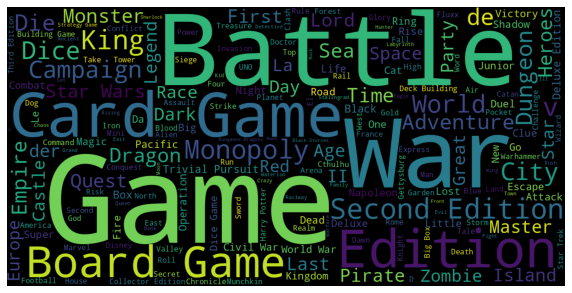

In [39]:
# Name word cloud
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
wordcloud = WordCloud(
        width=1200,
        height=600,
    ).generate(' '.join(rated.name))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis(False);

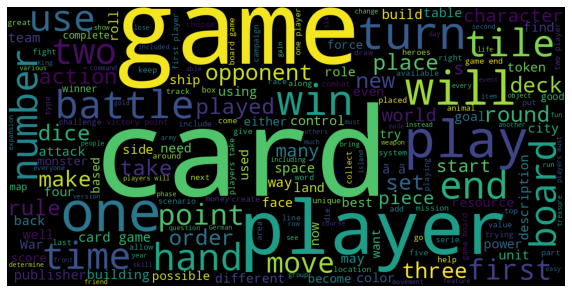

In [40]:
# Description word cloud
wordcloud = WordCloud(
        width=1200,
        height=600,
    ).generate(' '.join(rated.description.dropna()))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis(False);

### Year Published
Publication years range from 3500 BCE to 2023 CE, although early years are essentially estimates, whereas future games are awaiting release. There's a number of games at year 0, but these are missing value indicators.

The number of games published by year grows until 2020, and declines after. This is possibly due to recent games not being updated on the platform yet.

In [41]:
y_pub = rated['year_published']
y_pub.describe()

count    23318.000000
mean      1986.641779
std        209.545550
min      -3500.000000
25%       2002.000000
50%       2012.000000
75%       2017.000000
max       2023.000000
Name: year_published, dtype: float64

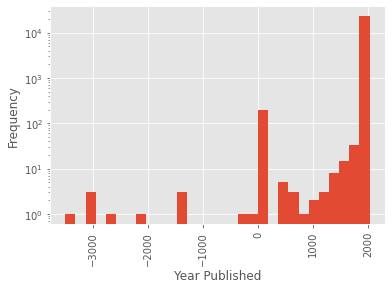

In [42]:
y_pub.plot.hist(bins=30);
plt.xlabel("Year Published")
plt.xticks(rotation=90);
plt.yscale('log');

In [43]:
# Check what year 0 games look like
rated.query("year_published == 0").head()

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
12,10502,boardgame,Poker Dice,Poker Dice is a dice game using five (5) speci...,0,2,12,10,10,10,...,5.394,1.7863,0.0,1040,13,7,20,177,54,1.259
509,10716,boardgame,Kemps,Kemps (also known as Canes) is played with two...,0,4,8,30,30,30,...,5.526,1.8085,0.0,98,2,1,8,34,6,1.167
1369,133425,boardgame,Quartett,This family of card games is enormously popula...,0,3,0,0,0,0,...,5.425,1.6830,0.0,976,5,0,8,105,10,1.000
1503,147392,boardgame,Colony Clash: Insect Warfare,Colony Clash: Insect Warfare is a card game wh...,0,2,4,15,15,15,...,5.491,2.1374,0.0,87,5,0,8,10,6,1.500
2624,104287,boardgame,Batanimo,"Batamino, a variant on War, has been designed ...",0,2,4,10,10,10,...,5.478,1.4401,0.0,82,0,0,0,4,2,1.000


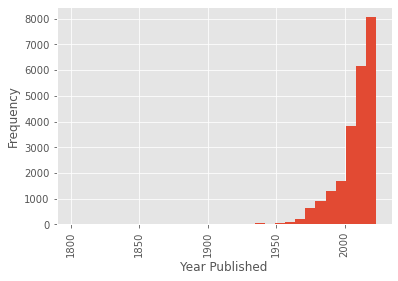

In [44]:
y_pub[y_pub > 1800].plot.hist(bins=30);
plt.xlabel("Year Published")
plt.xticks(rotation=90);

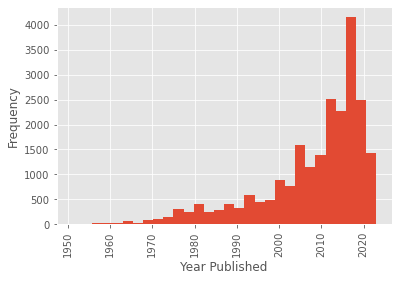

In [45]:
y_pub[y_pub > 1950].plot.hist(bins=30);
plt.xlabel("Year Published");
plt.xticks(rotation=90);

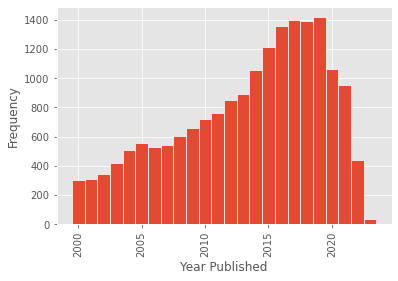

In [46]:
y_pub[y_pub >= 2000].plot.hist(
    bins=np.arange(1999.5, y_pub.max() + 1.5),
    linewidth=.7,
    edgecolor='white')
plt.xlabel("Year Published");
plt.xticks(rotation=90);

### Player numbers
Games have a field for minimum and maximum players.
For ~19% of games, these are the same.

Zeros are missing values placeholders, although an interesting entry is [Miscellaneous Game Compilation](https://boardgamegeek.com/boardgame/96627/miscellaneous-game-compilation) which is a placeholder entry for various compilations of public domain games, and hence doesn't have a defined number of players.

The largest min players is 10, but the largest max players value is 999.

In [47]:
pl = rated[['players_min', 'players_max']]
pl.describe()

,players_min,players_max
count,23318.000000,23318.000000
mean,1.995454,5.755168
std,0.699209,14.898702
min,0.000000,0.000000
25%,2.000000,4.000000
50%,2.000000,4.000000
75%,2.000000,6.000000
max,10.000000,999.000000


In [48]:
# ratio of games where min and max players are the same
(pl.players_min == pl.players_max).mean()

0.18925293764473797

In [49]:
# the 10 players min is actually only 2 games
pl.query("players_min == 10")['players_max'].describe()

count      2.000000
mean      65.000000
std       49.497475
min       30.000000
25%       47.500000
50%       65.000000
75%       82.500000
max      100.000000
Name: players_max, dtype: float64

First let's take a look at player numbers at the smaller end of the spectrum. We'll split games by max players of 24.

In [50]:
split = 24
pl_few = pl.query(f"players_max <={split}")
pl_many = pl.query(f"players_max > {split}")
print(pl_few.shape)
print(pl_many.shape)

(23035, 2)
(283, 2)


This is a heatmap of games where `player_max <= 24`. The biggest categories are 2-player games, and 2-4 players games.

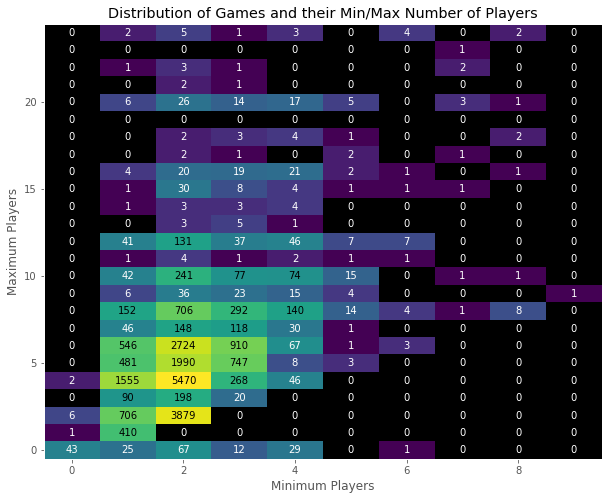

In [51]:
plt.figure(figsize=(10, 8))
plt.grid(False)
bin_edges = [np.arange(pl_few.players_min.min() - 0.5, pl_few.players_min.max() + 1.5),
             np.arange(pl_few.players_max.min() - 0.5, pl_few.players_max.max() + 1.5)]

# Viridis default for bad values is transparent, so set manually.
viridis = mpl.colormaps['viridis']
viridis.set_bad((0, 0, 0, 1))

# Use a log color scale.
# Bad values arise for log10(0).
# ss are counts in each bin used in text plotting,
# xs and ys are bin edges.
ss, xs, ys, _ = plt.hist2d(
    pl_few.players_min, 
    pl_few.players_max, 
    bins=bin_edges,
    norm=mpl.colors.LogNorm(),
    cmap=viridis
)

# Convert the bin edges to coordinates in centre of bin.
# Then repeat/tile them into 1D. 
xs, ys = xs[:-1], ys[:-1]
x_len, y_len = xs.shape[0], ys.shape[0]
xs = xs.repeat(y_len) + 0.5
ys = np.tile(ys, x_len) + 0.5
ss = ss.flatten()

# Find the log halfway point, which will be the colour scale halfway point
ss_half = 10**(np.log10(ss.max())/2)

# Plot counts on top, switching font colour for visibility
for s, x, y in zip(ss, xs, ys):
    c = 'white' if s < ss_half else 'black'
    plt.text(x, y, int(s), color=c, ha='center', va='center')

plt.xlabel('Minimum Players')
plt.ylabel('Maximum Players')
plt.title('Distribution of Games and their Min/Max Number of Players');

Peeking at 0 player games, looks like they are missing values.

In [52]:
rated.query("players_min == 0").head()

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
5562,126463,boardgame,Spectrix,"Game play in Spectrix is akin to Rummy, but wi...",2012,0,0,0,0,0,...,5.491,1.3806,0.0,170,8,0,3,15,3,1.667
7870,96628,boardgame,Miscellaneous Game Compilation,A placeholder entry for compendiums/compilatio...,0,0,0,0,0,0,...,5.461,1.5261,0.0,1165,27,1,10,316,15,1.400
8783,12541,boardgame,Card Games Around the World,Most of us know a handful of classic card game...,1981,0,0,0,0,0,...,5.540,1.2795,0.0,172,3,6,14,42,2,2.500
9754,2356,boardgame,Scrabble Sentence Cube Game,"Players in turn roll the 21 word cubes, set th...",1971,0,0,10,10,10,...,5.437,1.7172,0.0,574,38,2,7,82,10,1.200
12474,10971,boardgame,Board and Table Games from Many Civilizations,Anybody that has looked in the Games section i...,1960,0,0,0,0,0,...,5.540,1.3942,0.0,107,1,7,26,27,3,2.333


In [53]:
rated.query("players_max == 0").head()

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
490,97469,boardgame,Blokus Junior,Blokus Junior is the perfect way to teach kids...,2010,2,0,15,15,15,...,5.536,1.2390,0.0,198,11,6,15,29,2,1.5
1369,133425,boardgame,Quartett,This family of card games is enormously popula...,0,3,0,0,0,0,...,5.425,1.6830,0.0,976,5,0,8,105,10,1.0
2848,6412,boardgame,Humm...ble,Humm...ble is much like charades with songs. ...,1991,4,0,45,45,45,...,5.482,1.7913,0.0,87,7,0,1,21,1,1.0
2984,4574,boardgame,Slang Teasers,"A version of a popular dictionary game, player...",1983,3,0,60,60,60,...,5.521,1.2286,0.0,101,5,1,3,21,4,2.0
3785,9508,boardgame,Golden Trivia Game: M*A*S*H Edition,This was one of a series of Golden themed triv...,1984,2,0,30,30,30,...,5.491,1.6128,0.0,125,7,3,6,19,0,0.0


Taking a look at games with `players_max > 24`, we see their player numbers span a wide range. In the plot below, each line is one game starting at the minimum player number, going up to the maximum player number

In [54]:
pl_many.describe()

,players_min,players_max
count,283.000000,283.000000
mean,2.441696,94.212014
std,1.588732,99.457452
min,1.000000,25.000000
25%,1.000000,66.000000
50%,2.000000,99.000000
75%,3.000000,99.000000
max,10.000000,999.000000


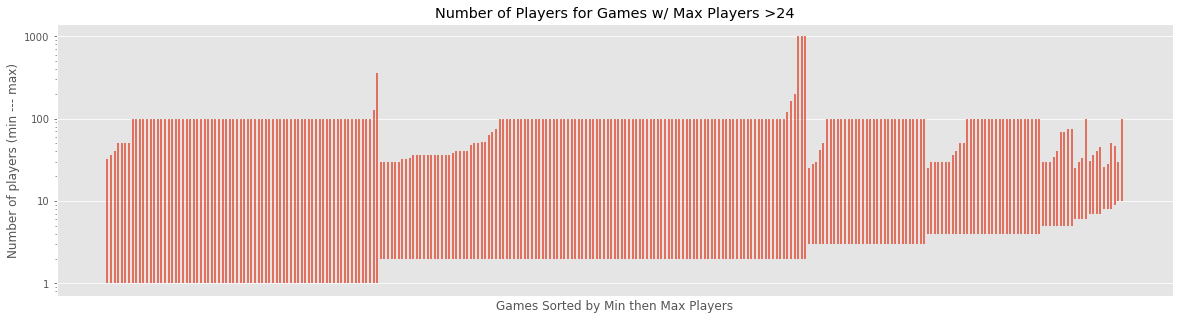

In [55]:
f, ax = plt.subplots(1, 1, figsize=(20,5))
pl_many = pl_many.sort_values(['players_min', 'players_max'])
plt.vlines(np.arange(1, pl_many.shape[0]+1), pl_many.players_min, pl_many.players_max)
plt.yscale('log')
plt.ylabel('Number of players (min --- max)')
plt.xlabel('Games Sorted by Min then Max Players')
plt.xticks([])
plt.title(f"Number of Players for Games w/ Max Players >{split}")
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


In [56]:
rated.query("players_max > 100").head()

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
47746,24969,boardgame,Pit Fighter: Fantasy Arena,Pit Fighter: Fantasy Arena is a multi mechanic...,2006,2,163,30,20,30,...,5.500,1.5428,0.0,199,31,3,21,39,5,1.800
47926,3867,boardgame,The Hammer of Thor: The Game of Norse Mythology,Probably the most comprehensive mythology game...,1980,1,362,120,120,120,...,5.480,1.8881,0.0,184,20,29,77,48,4,3.500
53239,60815,boardgame,Black Powder: Second Edition,Miniature Wargame rules for the era of horse a...,2009,2,120,360,120,360,...,5.634,1.4673,0.0,398,3,7,32,61,14,2.714
61302,28567,boardgame,"I Don't Know, What Do You Want to Play?",Unique game whose components consist of a card...,2007,2,999,5,5,5,...,5.564,2.1077,0.0,113,0,3,78,65,17,1.059
65320,189890,boardgame,Scrimish Card Game,Scrimish is a fast moving card game that pits ...,2015,2,999,100,10,100,...,5.548,1.5372,0.0,1027,36,5,35,95,8,1.125


### Playing Time

The `playtime_max` column is actually redundant with the playtime column.
As well, `playtime_min` and the same as `playtime_max` 65% of the time. Most games take under 1.5h to play. 

In [57]:
pt = rated[['playtime', 'playtime_min', 'playtime_max']]
pt.describe()

,playtime,playtime_min,playtime_max
count,23318.000000,23318.000000,23318.000000
mean,90.825028,62.452397,90.825028
std,522.300785,431.042046,522.300785
min,0.000000,0.000000,0.000000
25%,25.000000,20.000000,25.000000
50%,45.000000,30.000000,45.000000
75%,90.000000,60.000000,90.000000
max,60000.000000,60000.000000,60000.000000


In [58]:
# playtime and playtime max cols are the same
(pt.playtime == pt.playtime_max).all()

True

In [59]:
# ratio of when playtime min == playtime max
(pt.playtime_min == pt.playtime_max).mean()

0.6533150355948194

In [60]:
pt.playtime_min.value_counts().head(10)

30     4754
60     3207
20     2866
45     2316
15     2075
120    1372
10     1360
90     1294
0       736
180     707
Name: playtime_min, dtype: int64

In [61]:
pt.playtime_max.value_counts().head(10)

30     4066
60     3411
45     2319
20     2255
120    1853
90     1832
15     1381
180     900
0       897
10      844
Name: playtime_max, dtype: int64

This is a heatmap plotting binned min vs max playtime. The biggest category is for games at 30 min. Notes 0's are missing value placeholders.

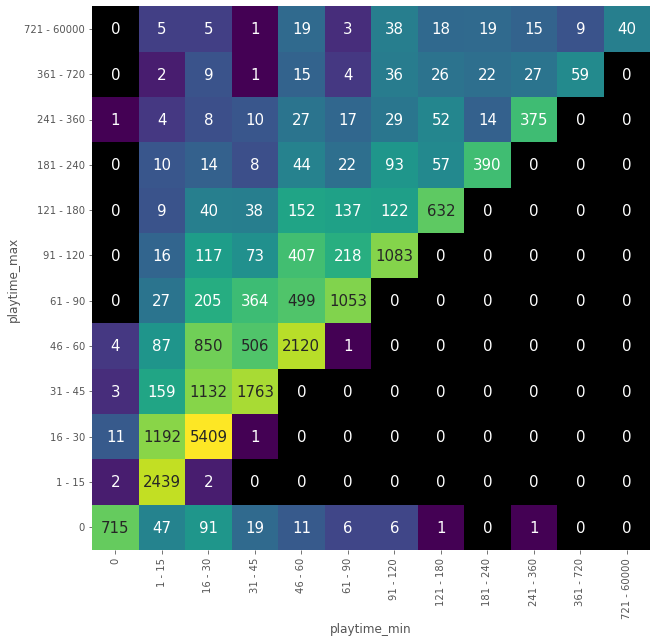

In [62]:
# Bin into unequal sized bins
# Note: pd cut is default (n1, n2] interval
bins = [-1, 0, 15, 30, 45, 60, 90, 120, 180, 4*60, 6*60, 12*60,
        pt.playtime_max.max()]

# Convenience func to generate bin names
def generate_bin_labels(bins):
    labels = []
    for i, left in enumerate(bins[:-1]):
        right = bins[i+1]
        if right == 0:
            labels.append("0")
        else:
            labels.append(f"{left+1} - {right}")
    return labels

pt_binned = pd.DataFrame()
pt_binned = (pt_binned
    .assign(
        playtime_min=pd.cut(
            pt.playtime_min,
            bins=bins,
            labels=generate_bin_labels(bins)),
        playtime_max=pd.cut(
            pt.playtime_max,
            bins=bins,
            labels=generate_bin_labels(bins))
        ))

# Generate a matrix for plotting using crosstab
f, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(
    ax=ax,
    data=
        pd.crosstab(pt_binned.playtime_min, pt_binned.playtime_max)
        .T.iloc[::-1,:], # flip, then reverse max axis
    annot=True,
    fmt='d',
    cmap=viridis,
    norm=mpl.colors.LogNorm(),
    cbar=False,
    annot_kws={'size': 15}
);


### Age

Most of the minimum ages are 8, 10, and 12.
0's are probably mostly missing value placeholders.


In [63]:
rated.age_min.describe()

count    23318.000000
mean         9.639892
std          3.649204
min          0.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         21.000000
Name: age_min, dtype: float64

In [64]:
rated.age_min.value_counts().head(5)

12    5167
8     4713
10    4385
14    2292
0     1390
Name: age_min, dtype: int64

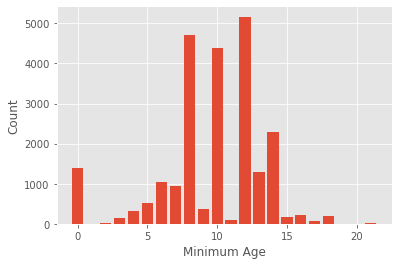

In [65]:
# plt bar has centered bars unlike hist
v_counts = rated.age_min.value_counts().sort_index()
plt.bar(x=v_counts.index, height=v_counts, align='center');
plt.xlabel('Minimum Age')
plt.ylabel('Count');

### Ratings

 The ratings columns are derived from user ratings.
 - ratings_n: the number of ratings users have given
 - ratings_mean: the average of user ratings
 - ratings_bayes_average: the 'geek rating'
 - ratings_stddev: standard deviation of user ratings
 - ratings_median: median user rating, unused
 - ratings_owned: how many users that have marked the game as being owned
 - ratings_trading: how many users are looking to trade away the game
 - ratings_wanting: users marked the game as wanted
 - ratings_wishing: users placed onto their wishlist
 - ratings_comments_n: how many times users have commented on the game
 - ratings_weights_n: times users have given a weight rating
 - ratings_weights_average: the average "complexity" rating users give a game, from 1 (light complexity) to 5 (heavy complexity)

In [66]:
# subset out for convenience
ratings = rated.loc[:,'ratings_n':]

In [67]:
# median is unused
ratings['ratings_median'].value_counts()

0.0    23318
Name: ratings_median, dtype: int64

In [68]:
# drop unused median
ratings = ratings.drop('ratings_median', axis=1)

To simplify looking at the ratings, below is 1) a heatmap of the correlation coefficients between the columns and 2) the heatmap after clustering.

Some observations:
- the number of regular ratings, weight ratings, comments, and wishing/wanting/trading/owned statuses are highly to fairly correlated with each other.
- number of regular or weight ratings isn't correlated with the average regular or weight rating.
- average rating has a mild correlation with the weight average rating, which could suggest more complex games are rated higher, and is worth further investigation.

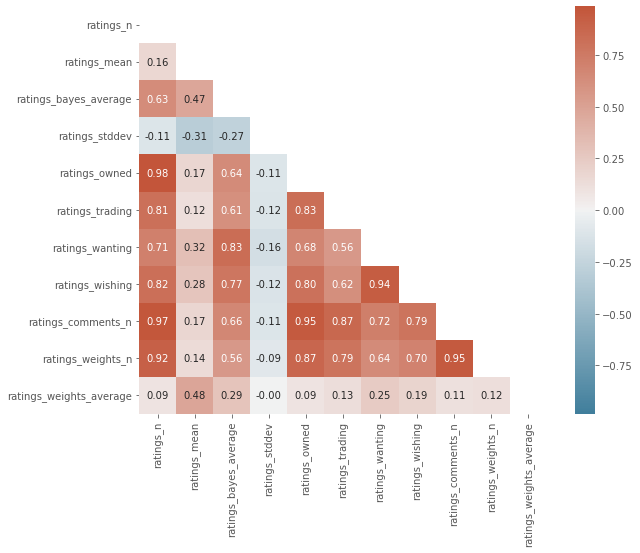

In [69]:
divergent = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(ratings.corr(), dtype=bool))
norm = mpl.colors.CenteredNorm(vcenter=0)
f, ax = plt.subplots(1,1, figsize=(10,7.5))
ax.set_facecolor('white')
sns.heatmap(ratings.corr(), mask=mask, square=True, annot=True, cmap=divergent, fmt=".2f", norm=norm, ax=ax);

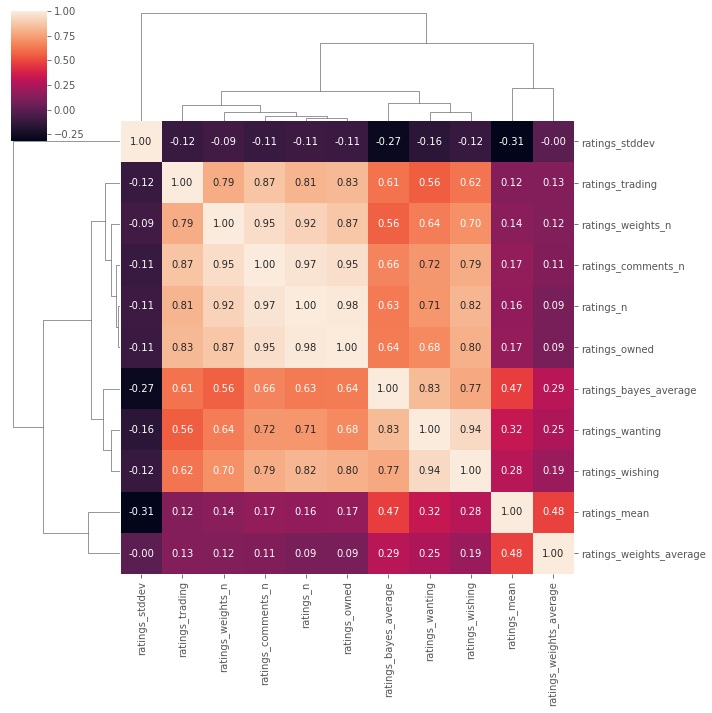

In [70]:
g = sns.clustermap(ratings.corr(), annot=True, fmt='.2f')

## Link data

### Tweaking the dataframe
Before we look at it, let's tweak the dataframe by:
- removing the prefix "boardgame" from the `type` column, and changing the dtype to categorical
- for `inbound`, fill missing with `False` and replace str `'true'` with `True`

Memory usage is not big anyways, but this does save some memory.

In [71]:
# cleaning up link dataframe to make it easier to work with
# and save a bit of space.
def tweak_link(df):
    return (df
        .assign(
            # Type column:
            # strip out redundant boardgame prefix
            # then convert to categorical.
            type=(df.type
                .str.replace("boardgame", "")
                .astype('category')
            ),
            # Values are either 'true' or None 
            inbound=(df.inbound
                .fillna(False)
                .replace({'true': True})
            )
        )
    )

display((link.memory_usage(deep=True).rename('Mem in MBs, Pre')).to_frame().T/2**20)
link = tweak_link(link)
display((link.memory_usage(deep=True).rename('Mem in MBs, Post')).to_frame().T/2**20)

,Index,boardgame_id,type,value,link_id,inbound
"Mem in MBs, Pre",0.000122,8.036789,74.221218,75.49738,8.036789,24.427446


,Index,boardgame_id,type,value,link_id,inbound
"Mem in MBs, Post",0.000122,8.036789,1.005514,75.49738,8.036789,1.004599


### Overview
This data is extracted from `<link>` xml tags.
- boardgame_id: the id of the boardgame the link belongs to
- type: the type of link e.g. the category, designer, etc.
- value: value associated with the link type
- link_id: and id for the link e.g. each board game category has its own id
- inbound: `False` (or `None` before cleaning) indicates that the boardgame is
linking out to a different data type (e.g. category). 
`True` indicates that other board games are linking into this boardgame,
as they are an implementation, compilation, or expansion of the incoming boardgame.
For example [Ghost of the Moor](https://boardgamegeek.com/boardgame/257273/ghosts-moor)
is an reimplemenation of [That's Life](https://boardgamegeek.com/boardgame/17240/s-life).

In [72]:
display(link.head())
print("\n", "INFO: ")
link.info()

,boardgame_id,type,value,link_id,inbound
0,101769,category,Dice,1017,False
1,101769,category,Economic,1021,False
2,101769,mechanic,Dice Rolling,2072,False
3,101769,mechanic,Roll / Spin and Move,2035,False
4,101769,designer,Wolfgang Kramer,7,False



 INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053398 entries, 0 to 1053397
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   boardgame_id  1053398 non-null  int64   
 1   type          1053398 non-null  category
 2   value         1053398 non-null  object  
 3   link_id       1053398 non-null  int64   
 4   inbound       1053398 non-null  bool    
dtypes: bool(1), category(1), int64(2), object(1)
memory usage: 26.1+ MB


In [73]:
# How many inbounds?
link.inbound.value_counts()

False    1044412
True        8986
Name: inbound, dtype: int64

In [74]:
inbounds = link[link.inbound]

In [75]:
inbounds.head()

,boardgame_id,type,value,link_id,inbound
55,304743,implementation,Absolute Dice,304740,True
147,257273,implementation,That's Life!,17240,True
491,342924,implementation,Timeline: Inventions,85256,True
1014,217470,implementation,Qwinto,183006,True
1066,214026,compilation,Cheaters' Chili,244805,True


In [76]:
au.display_id_link(17240)

### Links of rated games
Let's restricted our analysis to 'rated' game as before.

In [77]:
rated_link = link[link['boardgame_id'].isin(rated['id'])]
print('Shape: ', rated_link.shape)
print('Inbound Counts: ', rated_link.inbound.sum())

Shape:  (364915, 5)
Inbound Counts:  4762


There are only 10 types of links, with widely differing values per type.

In [78]:
# Number of unique values per each link type
rated_link.groupby('type')['value'].nunique()

type
artist            11556
category             84
compilation        2050
designer          10389
expansion         24734
family             3697
implementation     6023
integration        2552
mechanic            187
publisher          7437
Name: value, dtype: int64

Let's take a closer look at the inbounds again.

For expansions, there is only one inbound expansion
 for the game [35035 World at War: Blood and Bridges](https://boardgamegeek.com/boardgame/35035/world-war-blood-and-bridges) which is described as a "stand-alone expansion"
  for [25729 World at War: Eisenbach Gap](https://boardgamegeek.com/boardgame/25729/world-war-eisenbach-gap).

Most expansion links are outbound, and link to board game expansions not included in this dataset.

In [79]:
rated_link.query("type == 'expansion' & inbound == True")

,boardgame_id,type,value,link_id,inbound
904300,35035,expansion,World at War: Eisenbach Gap,25729,True


In [80]:
au.display_id_link(25729)
au.display_id_link(35035)

In [81]:
# Outbound expansions
rated_link.query("type == 'expansion' and inbound == False").shape

(32855, 5)

For compilations, an inbound entry indicates that the boardgame is a compilation 
that includes its `link_id` target game (with the target's name under `value`)

The number of inbound records is larger than the number of outbound records,
 probably because compilations will include expansions etc. not included in this dataset.

In [82]:
# inbound compilation records
(rated_link.query("type == 'compilation' and inbound == True")
    .pipe(lambda df: display(df.head(), df.shape)))

au.display_id_link(147154)

,boardgame_id,type,value,link_id,inbound
2038,147154,compilation,Blue Moon,9446,True
2039,147154,compilation,Blue Moon: Buka Invasion,22097,True
2040,147154,compilation,Blue Moon: Earth Spirit,64133,True
2041,147154,compilation,Blue Moon: Emissaries & Inquisitors – Allies,19742,True
2042,147154,compilation,Blue Moon: Emissaries & Inquisitors – Blessings,19743,True


(1613, 5)

In [83]:
# Non_inbound compilation records
rated_link.query("type == 'compilation' and inbound == False").shape

(1171, 5)

For implementations:
- an inbound record means the entry reimplements the linked game
- an outbound record means the entry is a base game that is reimplemented by the link
Thus, every inbound record should have a corresponding outbound record.

For the rated games, there are both unmatched inbound and outbound links,
as implementations or base games can fail to have the thirty ratings to be 
included in the rated games data.

Including all games still leaves a couple hundred of unpaired inbound/outbound links.
From a quick inspection,
it seems that at least some unpaired inbound links are due to their base games
being a board game expansion (and hence not included in the data download).
Similarly, this is true for some implementations of unpaired outbound links.
Additionally, some implementations from unpaired outbound links have an `id`
that is higher than the maximum id I used when downloading the data,
and hence is just missing from this dataset.

In [84]:
def process_implementation_links(link_df: pd.DataFrame) -> dict:
    """Filter implementation links and split into paired and unpaired sets."""
    # Filter for implementations only
    impl_only = link_df.query("type == 'implementation'")
    # Check for duplicate entries
    if impl_only.duplicated().sum() > 0:
        warn("WARNING: duplicated implementation entries found")
    # Gather inbound and outbound links to separate frames
    # while renaming for clarity,
    # and using base and implementation ids as the index
    inbound = (impl_only[impl_only.inbound == True]
        .rename({'boardgame_id': 'impl', 'link_id': 'base'}, axis='columns')
        .set_index(['base', 'impl'], verify_integrity=True))
    outbound = (impl_only[impl_only.inbound == False]
        .rename({'link_id': 'impl', 'boardgame_id': 'base'}, axis='columns')
        .set_index(['base', 'impl'], verify_integrity=True))
    # Split unpaired links and paired links into separate frames 
    unpaired_inb = inbound.loc[inbound.index.difference(outbound.index),:]
    unpaired_outb = outbound.loc[outbound.index.difference(inbound.index),:]
    paired = (inbound
        .loc[inbound.index.intersection(outbound.index), :]
        .reset_index()
        .drop(columns='inbound'))
    # Sanity check the sizes of the sets
    total = unpaired_inb.shape[0] + unpaired_outb.shape[0] + paired.shape[0]*2
    assert (total == impl_only.shape[0])
    # Return as dict
    return {'unpaired_inbound': unpaired_inb,
            'unpaired_outbound': unpaired_outb,
            'paired': paired}

impl_rated = process_implementation_links(rated_link)
impl = process_implementation_links(link)
t = Template(
    "${game_type}: "
    "unpaired inbound-${unp_in}, "
    "unpaired outbound-${unp_out}, "
    "paired-${p}")
print(t.substitute(
    game_type="Rated games",
    unp_in=impl_rated['unpaired_inbound'].shape[0],
    unp_out=impl_rated['unpaired_outbound'].shape[0],
    p=impl_rated['paired'].shape[0]
))
print(t.substitute(
    game_type="All games",
    unp_in=impl['unpaired_inbound'].shape[0],
    unp_out=impl['unpaired_outbound'].shape[0],
    p=impl['paired'].shape[0]
))

Rated games: unpaired inbound-417, unpaired outbound-1672, paired-2731
All games: unpaired inbound-159, unpaired outbound-206, paired-5849


In [85]:
impl['unpaired_inbound'].head()

,,type,value,inbound
base,impl,,,
158,180325,implementation,Elfengold,True
177,184424,implementation,Advanced Civilization,True
227,107551,implementation,Knightmare Chess,True
1248,10707,implementation,Hacker II: The Dark Side,True
1361,229218,implementation,Die Siedler von Catan: Historische Szenarien II,True


In [86]:
for id in impl['unpaired_inbound'].head().index.get_level_values('base'):
    au.display_id_link(id)

In [87]:
impl['unpaired_outbound'].head()

,,type,value,inbound
base,impl,,,
52,30643,implementation,Mighty Empires: Warhammer Expansion,False
79,22160,implementation,"EuroFront: The War in Europe, 1936-45 – Second...",False
110,367842,implementation,Leylines,False
122,368061,implementation,Zoo Vadis,False
294,363455,implementation,Keydom's Dragons,False


In [88]:
for id in impl['unpaired_outbound'].head().index.get_level_values('impl'):
    au.display_id_link(id)

In [89]:
impl['paired'].head()

,base,impl,type,value
0,304740,304743,implementation,Absolute Dice
1,17240,257273,implementation,That's Life!
2,85256,342924,implementation,Timeline: Inventions
3,183006,217470,implementation,Qwinto
4,160436,188561,implementation,Lost Legacy: Binbo Tantei to Inbo no Shiro


#### Top 20 values by type
Let's plot the top 20 values for each type for rated links,
 i.e. artists, cateogies, etc. with most board games associated with them.
We'll drop the inbound links to make things simpler.

Note the appearance of special values that look like "(*)", e.g. "(Uncredited)".

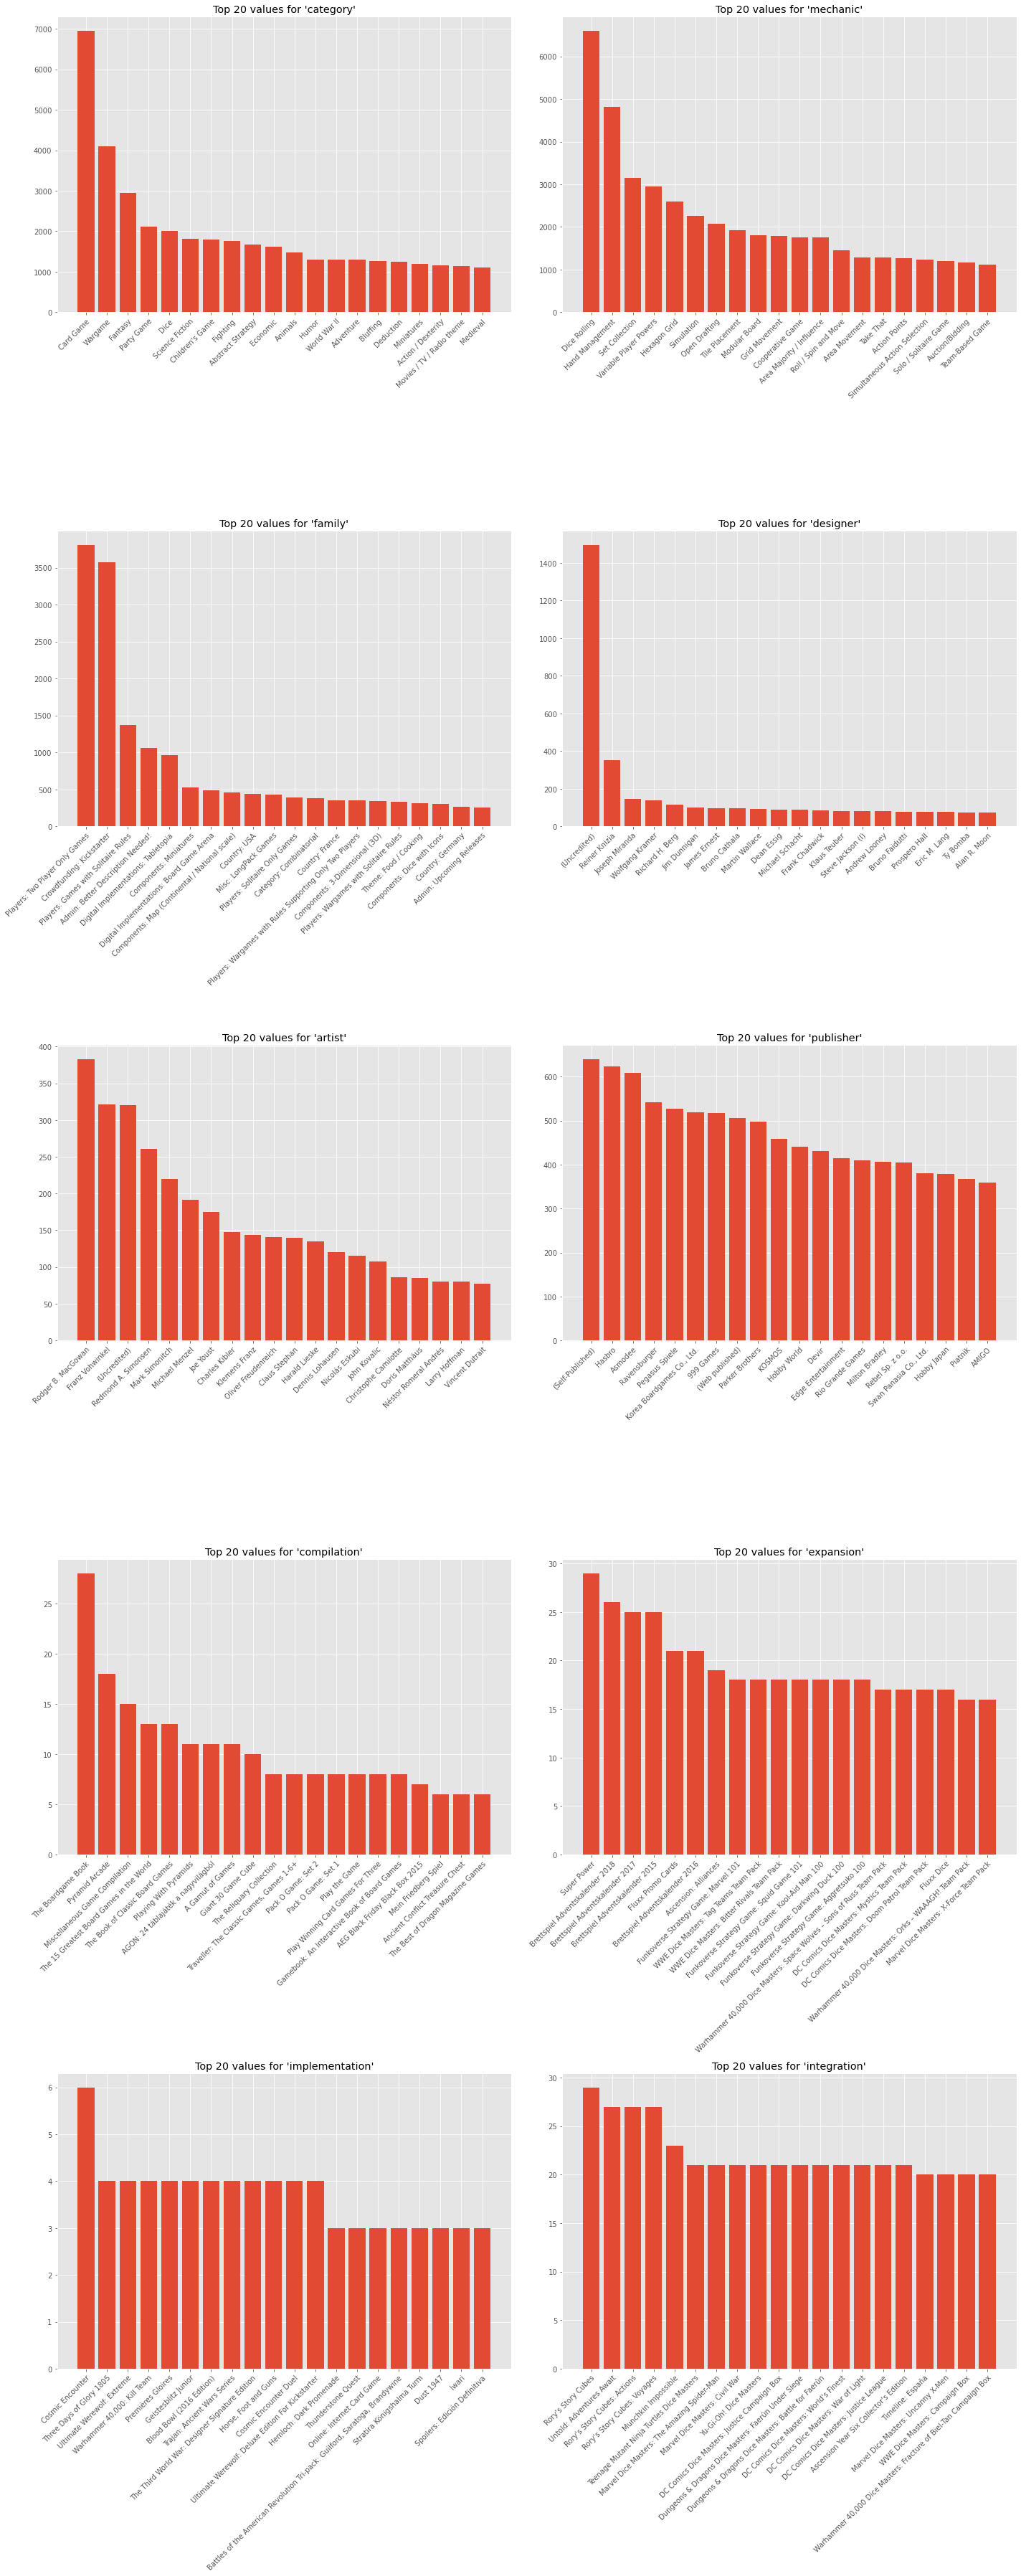

In [90]:
def plot_top_link_values(
        link_df: pd.DataFrame,
        ax: mpl.axes.Axes,
        link_type: str,
        n: int=20,
        drop_inbounds: bool=True,
        drop_remaining: bool=True) -> pd.Series:
    TYPE_KEY = 'type'
    VAL_KEY = 'value'
    INBOUND_KEY = 'inbound' 
    # Optionally drop inbound links
    if drop_inbounds:
        link_df = link_df[~link_df[INBOUND_KEY]]
    # Count the values
    cnt = (link_df
        .query(f"{TYPE_KEY} == '{link_type}'")
        [VAL_KEY]
        .value_counts()
    )
    # Drop remaining, or convert to 'other'
    if drop_remaining:
        cnt = cnt.head(n)
    else:
        top = cnt.head(n)
        cnt = (cnt
            .groupby(lambda idx: idx if idx in top.index else 'Other')
            .sum()
        )
    
    # Plot onto bars
    ax.bar(cnt.index, cnt)
    # Redraw figure to load xtick labels, otherwise labels are empty
    ax.get_figure().canvas.draw_idle() # OO version of plt.draw()
    # Rotate tick labels
    ax.set_xticks(
        ax.get_xticks(),
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    # Set title
    ax.set_title(f"Top {n} values for '{link_type}'")
        
    return cnt

f, axs = plt.subplots(5,2, figsize=(20, 50))
axs = axs.flatten()

for i, type in enumerate(rated_link.type.unique()):
    plot_top_link_values(rated_link, axs[i], type)
    

plt.tight_layout()


For rated links, `"(Uncredited)"` is only present for artists and designers,
whereas the other special values are only for publishers.

In [91]:
# Get all the '(*)' type of values and count them
# Highlight for display
special_links = (rated_link
    [rated_link.value.str.contains(r"^\(.*\)$")]
    .groupby('type')
    [['type', 'value']]
    .value_counts()
    .unstack(level=1)
    .style.applymap(
        lambda e: 
        "background-color:yellow; color:black;" if e != 0 else ""))

special_links


value,(Looking for a publisher),(Public Domain),(Self-Published),(Uncredited),(Unknown),(Web published)
type,,,,,,
artist,0,0,0,320,0,0
category,0,0,0,0,0,0
compilation,0,0,0,0,0,0
designer,0,0,0,1495,0,0
expansion,0,0,0,0,0,0
family,0,0,0,0,0,0
implementation,0,0,0,0,0,0
integration,0,0,0,0,0,0
mechanic,0,0,0,0,0,0


#### Top 20 games by type
We can count also the number of categories/artists/publishers etc.
associated with each game.

In [92]:
# Do games have more than one category etc?
# Take all rated games, count for each.
# outbound only 
def count_links(
    game_df: pd.DataFrame,
    link_df: pd.DataFrame,
    drop_outbounds=False,
    drop_inbounds=False,
) -> pd.DataFrame:
    if drop_outbounds and drop_inbounds:
        raise ValueError("Must keep one of outbounds or inbounds.")
    # Optionally drop inbounds/outbounds
    elif drop_inbounds:
        link_df = link_df.query("inbound == False")
    elif drop_outbounds:
        link_df = link_df.query("inbound == True")
    else:
        pass

    # Count links per game
    return (game_df
            .merge(
                # Rename for clarity 
                link_df.rename(columns={'type': 'link_type'}),
                left_on='id',
                right_on='boardgame_id')
            [['id', 'link_type']]
            .groupby('id')
            .value_counts()
            .unstack())


link_counts = count_links(rated, rated_link, drop_inbounds=True) 
link_counts.head()

link_type,artist,category,compilation,designer,expansion,family,implementation,integration,mechanic,publisher
id,,,,,,,,,,
1,2,3,0,1,0,3,0,0,6,9
2,1,2,0,1,0,3,1,0,1,2
3,1,2,0,1,0,6,1,0,6,17
4,1,1,0,1,0,3,0,0,4,1
5,2,2,0,1,2,1,0,0,7,11


This is a histogram of board games
for each link type and the number of links associated with each board game.

Note for some games the count can get quite high, e.g. for artist.

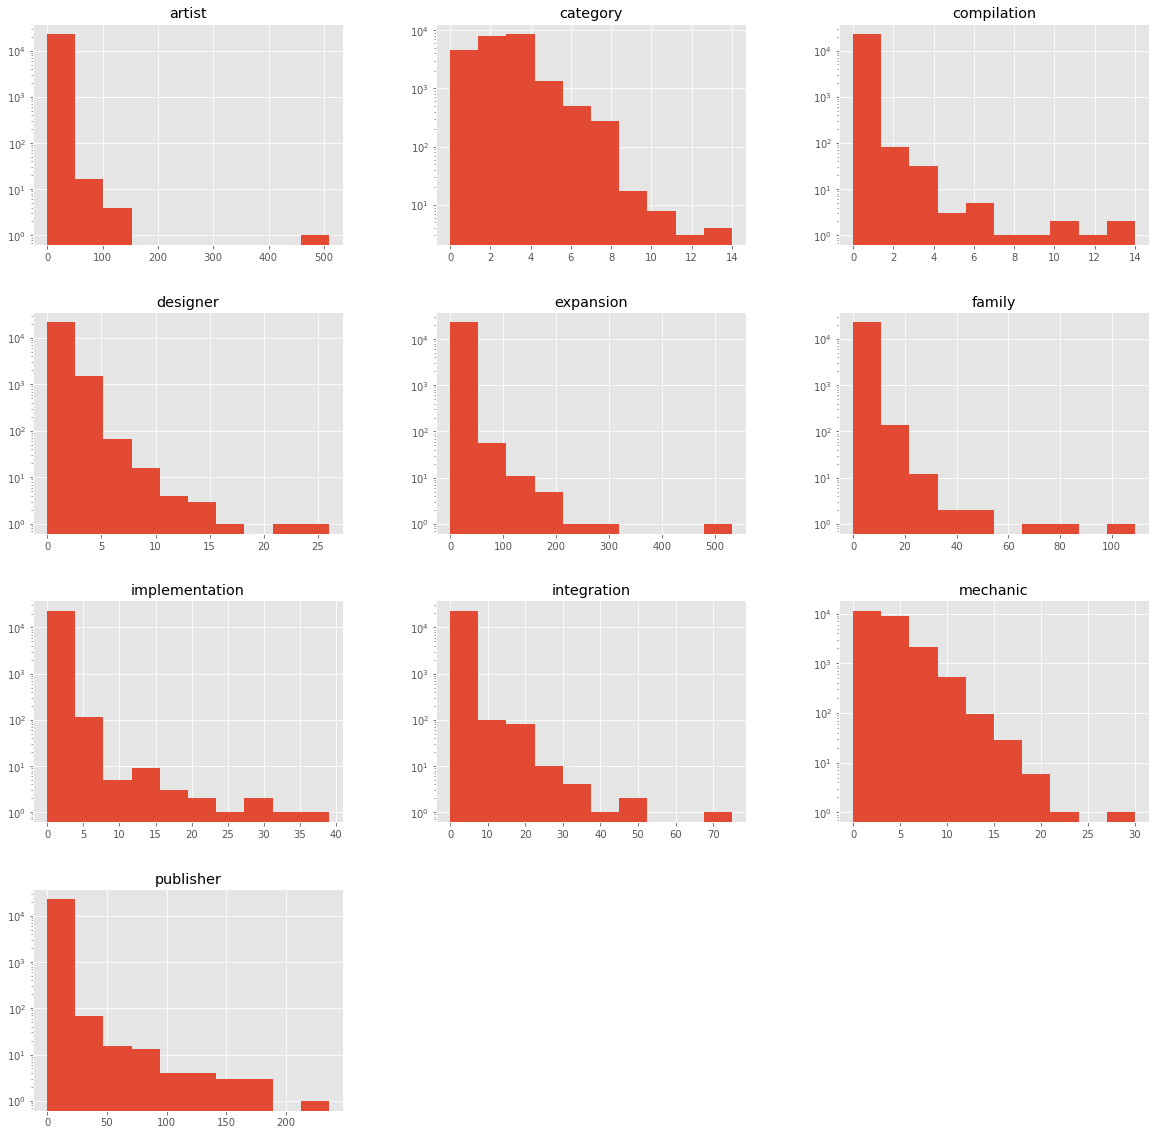

In [93]:
link_counts.hist(figsize=(20,20), log=True);

These are the top 20 games for each type.

For something like Magic the Gathering, it makes sense that the number of artists
is so high, as it is a trading card game with lots of individual artists
contributing to the design of the cards.

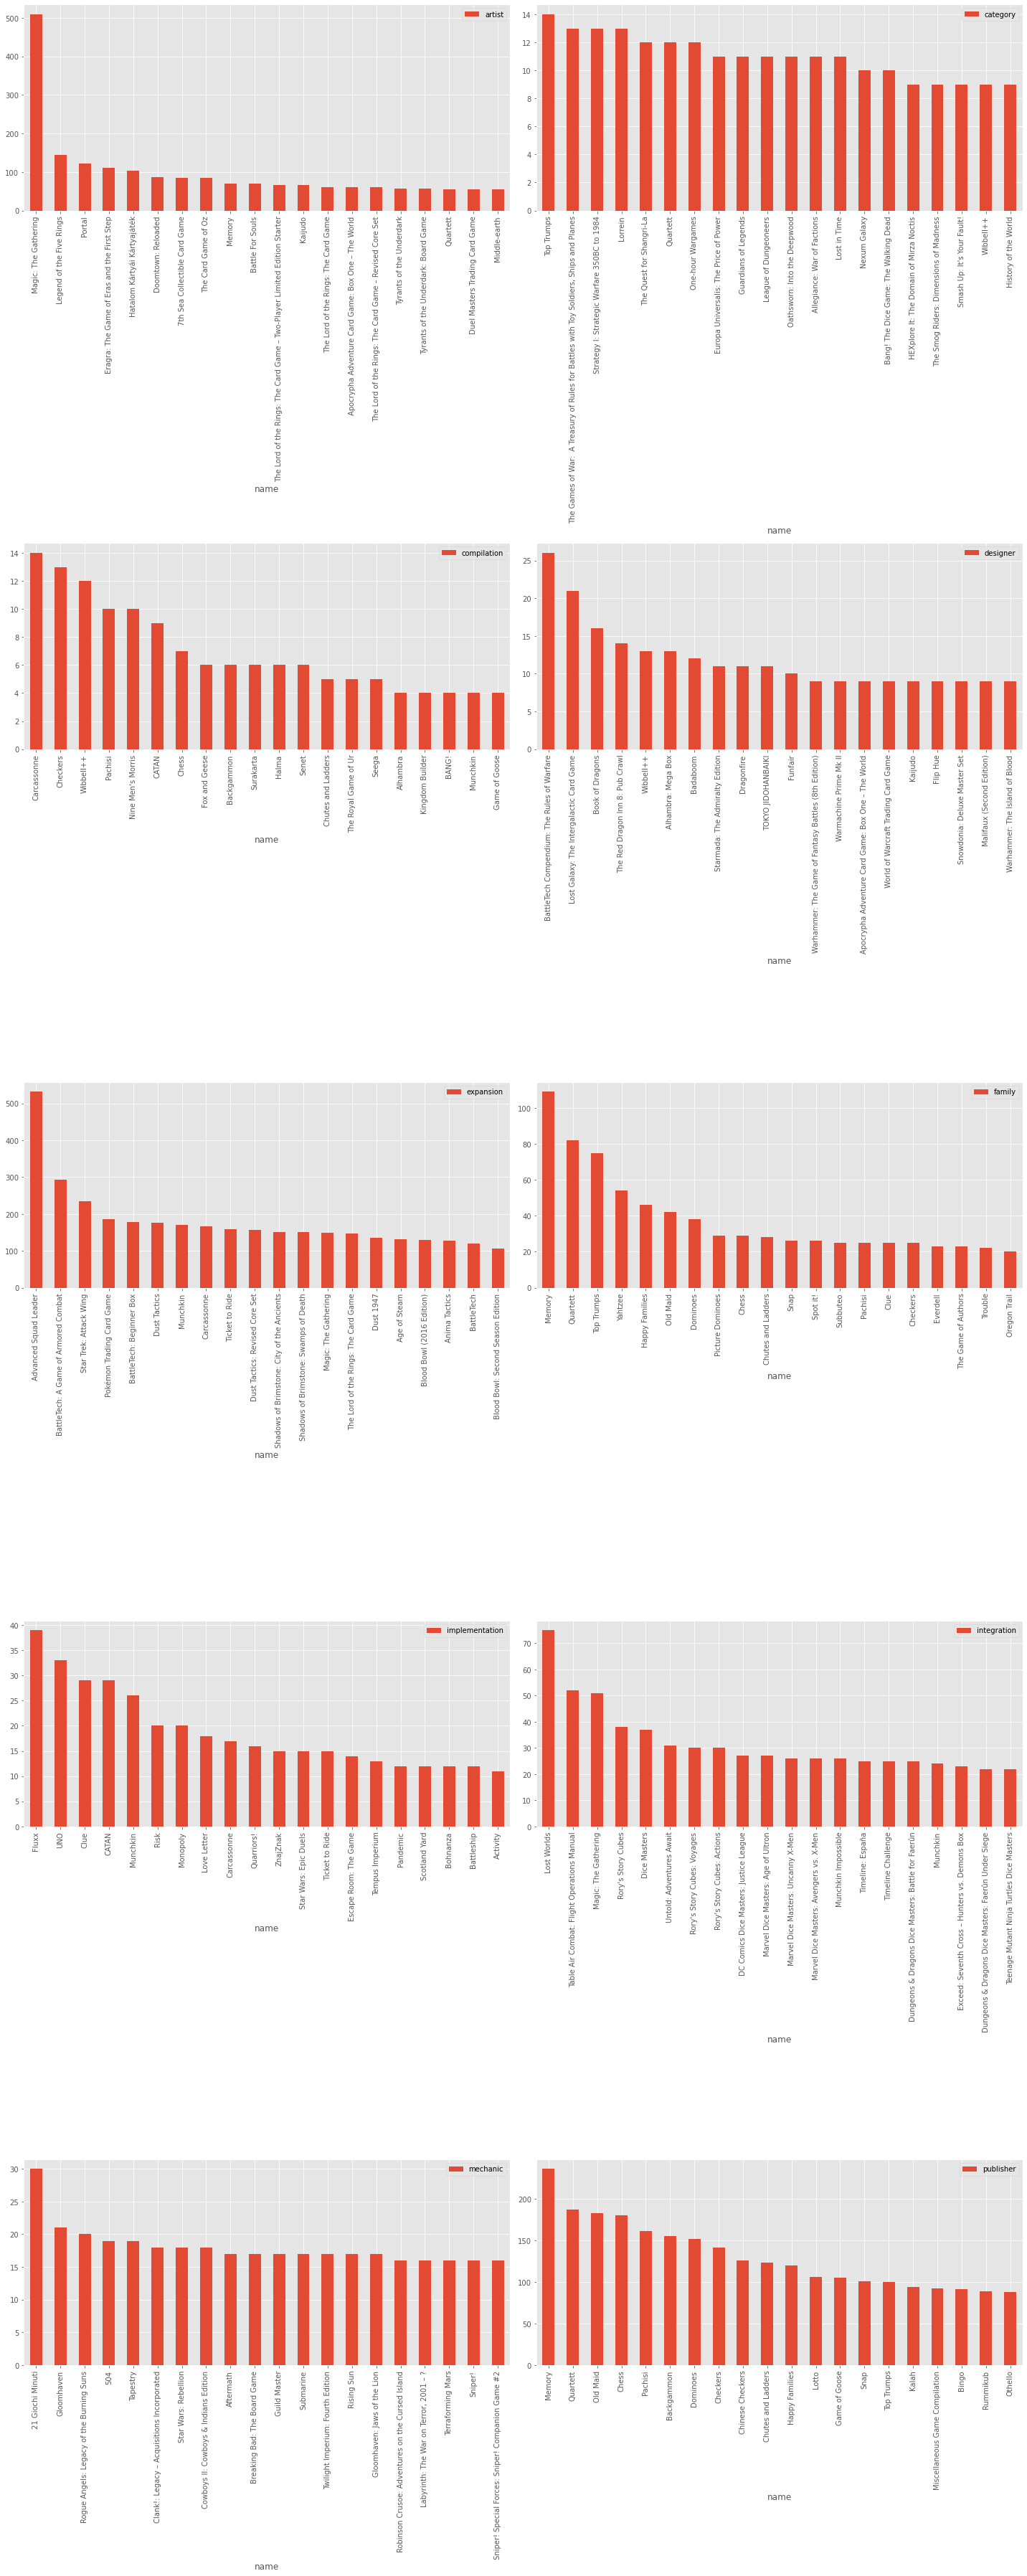

In [94]:
def plot_top_link_counts_by_game(
    link_counts: pd.DataFrame,
    n: int=20,
    fig_rows: int=5,
    fig_cols: int=2,
    fig_size: tuple[int, int]=(20, 50)) -> None:
    f, axs = plt.subplots(fig_rows, fig_cols, figsize=fig_size)
    axs = axs.flatten()
    for i, col in enumerate(link_counts.columns):
        df = (link_counts
            .sort_values(by=col, ascending=False)
            .head(20)
            [[col]]
            .merge(
                right=rated[['id','name']],
                left_on='id',
                right_on='id')
            .plot.bar(ax=axs[i], x='name', y=col))
    plt.tight_layout()
        
plot_top_link_counts_by_game(link_counts);

#### Top Inbound Links

For compilations, some of the largest compilations are things like
[The Board Game Book](https://boardgamegeek.com/boardgame/7159/boardgame-book)
that compile a lot of classic games.

Another example of a large compilation is
[Snowdonia: Deluxe Master Set](https://boardgamegeek.com/boardgame/255924/snowdonia-deluxe-master-set),
which includes the base Snowdonia game as well as a large number of previously
separate scenarios.
Conceptually, I find it hard to distinguish this from games that are annotated
as reimplementing a number of games, such as 
[Men of Iron Battles Tri-Pack](https://boardgamegeek.com/boardgame/293959/men-iron-battles-tri-pack-men-iron-infidel-blood-r)
or [Elfenroads](https://boardgamegeek.com/boardgame/180325/elfenroads),
at least from their description anyways.

Note: There is only one board game/expansion with inbounds links.

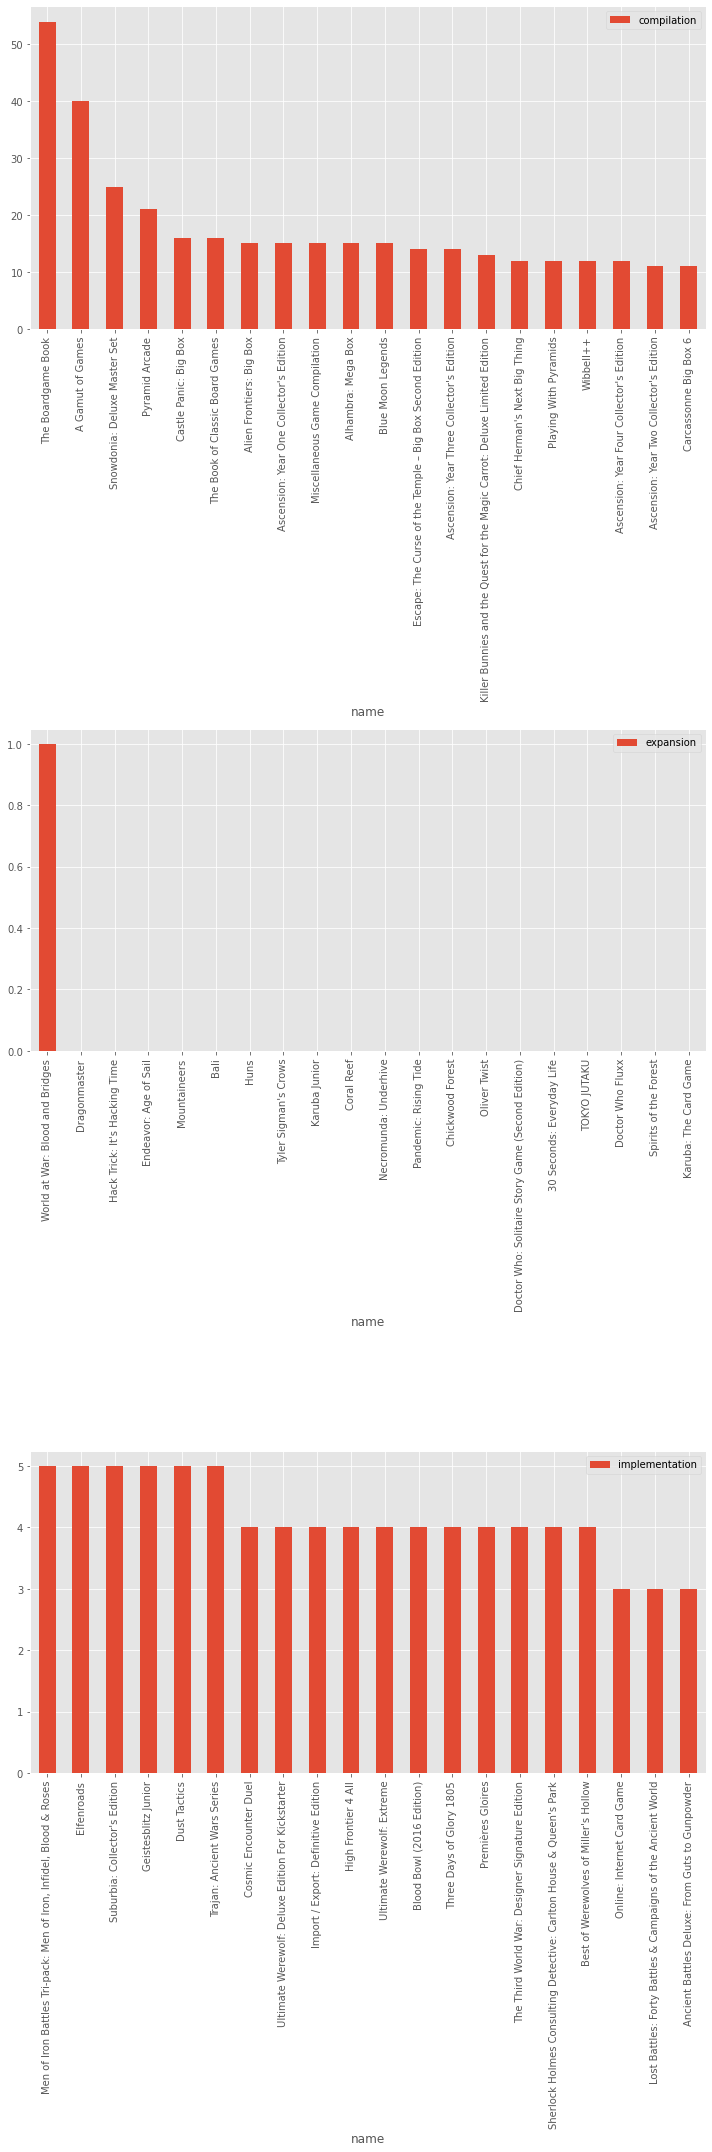

In [95]:
# Get inbound counts
link_counts_inb = count_links(rated, rated_link, drop_outbounds=True)
# Only get columns where counts aren't 0
link_counts_inb = (link_counts_inb
    .loc
    [:, link_counts_inb.sum().mask(lambda s: s == 0).dropna().index])
plot_top_link_counts_by_game(link_counts_inb, fig_rows=3, fig_cols=1, fig_size=(10, 30))

## Poll Data
I've decided to omit looking at polling data for now to simplify the analysis.

## Part 3 When is the golden age of board games
- link data rise of certain types of games

### Trends of Self-Published Board Games?

In [96]:
def plot_self_published_by_year(
    game_df: pd.DataFrame,
    link_df: pd.DataFrame,
    starting_year: int=1990) -> None:
    SELF_PUB_VAL = 	'(Self-Published)'
    WEB_PUB_VAL = '(Web published)'
    result = (game_df
        # Select columns
        [['id', 'year_published']]
        # Merge to publisher links
        .merge(
            right=link_df.query("type == 'publisher'"),
            left_on='id',
            right_on='boardgame_id',
            validate='1:m')
        # Select columns and rename
        [['id', 'year_published', 'value']]
        .rename(columns={'value':'publisher'}))
    print(result.head())
    
    result.groupby()
    # Try stacked bar plota

    # plot fraction

plot_self_published_by_year(rated, rated_link)

      id  year_published        publisher
0  13260            1975     Ravensburger
1  10502               0  (Public Domain)
2  10502               0        (Unknown)
3  10502               0            Argos
4  10502               0         Autruche


TypeError: You have to supply one of 'by' and 'level'

### Thing


In [ ]:
pd.Series([1,2,3], index=["a", "b", "c"]) * pd.Series([4,5,6], index=["c", "d", "a"])

a     6.0
b     NaN
c    12.0
d     NaN
dtype: float64

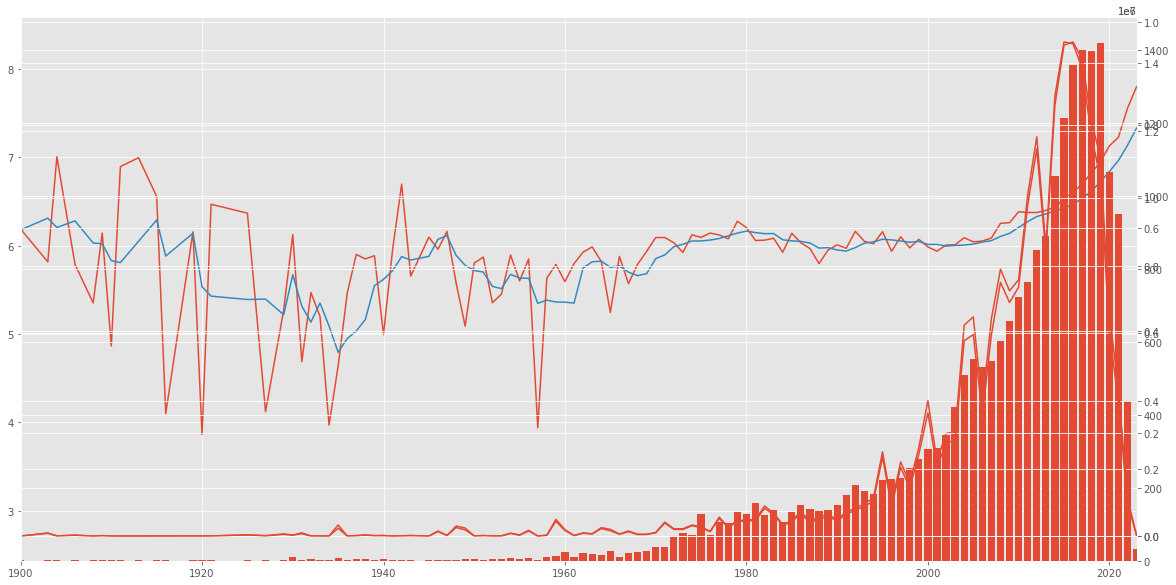

In [ ]:
def plot_ratings_by_time( game_df: pd.DataFrame) -> None:
    f, ax = plt.subplots(1, 1, figsize=(20,10))
    n_games_per_year = (rated
        .groupby('year_published')
        ['id'].count())
    n_ratings_per_year = (rated
        .groupby('year_published')
        ['ratings_n'].sum())
    mean_rate_by_year = (rated
        .groupby('year_published')
        ['ratings_mean'].mean())
    weighted_rate_by_year = (
        # Multiply by index
        mean_rate_by_year * n_ratings_per_year
    )
         
    
    ax.set_xlim(1900, 2023)
    ax.plot(mean_rate_by_year.index, mean_rate_by_year)
    ax.plot(
        mean_rate_by_year.index,
        mean_rate_by_year.rolling(window=5).mean())
    n_ax = ax.twinx() # for n_games_per_year
    n_ax.bar(n_games_per_year.index, n_games_per_year)
    n_rate_ax = ax.twinx()
    n_rate_ax.plot(n_ratings_per_year.index, n_ratings_per_year)
    weight_rate_ax = ax.twinx()
    weight_rate_ax.plot(weighted_rate_by_year.index, weighted_rate_by_year)
    # Cosmetics
    # Turn off gridlines
    # Gray down bar plots
    # Change colour of line?
    # Change dots on line?

plot_ratings_by_time(rated)